버전 확인 및 라이브러리 설치

In [1]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
!head /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 85
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
stepping	: 3
microcode	: 0xffffffff
cpu MHz		: 2000.144
cache size	: 39424 KB
physical id	: 0


In [3]:
# Install MMCV
!pip install -U openmim
!mim install mmengine
!mim install "mmcv>=2.0.0rc1"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 58.3 MB/s eta 0:00:00
Looking in links: https://download.openmmlab.com/mmcv/dist/cu118/torch2.0.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.2/433.2 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.3/250.3 kB 28.9 MB/s eta 0:00:00
Looking in links: https://download.openmmlab.com/mmcv/dist/cu118/torch2.0.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.4/74.4 MB 8.7 MB/s eta 0:00:00


In [4]:
!rm -rf mmsegmentation
!git clone https://github.com/open-mmlab/mmsegmentation.git
%cd mmsegmentation
!pip install -e .

Cloning into 'mmsegmentation'...
remote: Enumerating objects: 15621, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 15621 (delta 1), reused 14 (delta 1), pack-reused 15603
Receiving objects: 100% (15621/15621), 20.89 MiB | 10.60 MiB/s, done.
Resolving deltas: 100% (11002/11002), done.
/content/mmsegmentation
Obtaining file:///content/mmsegmentation
  Preparing metadata (setup.py) ... done
  Running setup.py develop for mmsegmentation


In [5]:
import os
import os.path as osp
import shutil

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

import torch, torchvision

import mmcv
import mmseg

In [6]:
print(torch.__version__, torch.cuda.is_available())
print(mmseg.__version__)

2.0.1+cu118 True
1.1.0


데이터 압축해제 및 폴더 생성

In [7]:
!mkdir data/

In [8]:
!unzip -qq /content/drive/MyDrive/open.zip -d data/

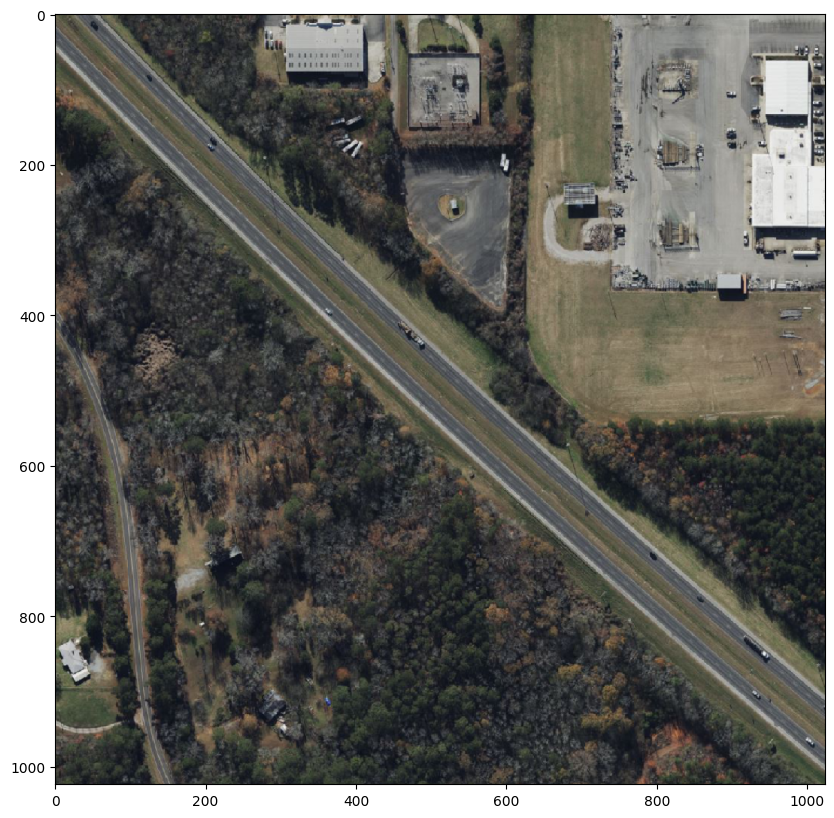

In [9]:
# 이미지 확인
img = mmcv.imread('data/train_img/TRAIN_0000.png')
plt.figure(figsize=(10, 10))
plt.imshow(mmcv.bgr2rgb(img))

plt.show()

In [10]:
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    img = img.reshape(shape)
    return img

# RLE 인코딩 함수
def rle_encode(mask):

    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [11]:
# validation 전략 수립 필요
df = pd.read_csv("data/train.csv")
df.head()

,img_id,img_path,mask_rle
0,TRAIN_0000,./train_img/TRAIN_0000.png,9576 7 10590 17 11614 17 12638 17 13662 17 146...
1,TRAIN_0001,./train_img/TRAIN_0001.png,208402 1 209425 6 210449 10 211473 14 212497 1...
2,TRAIN_0002,./train_img/TRAIN_0002.png,855 34 15654 9 16678 9 16742 8 17702 9 17766 9...
3,TRAIN_0003,./train_img/TRAIN_0003.png,362 6 745 15 798 22 900 25 1385 8 1828 16 1924...
4,TRAIN_0004,./train_img/TRAIN_0004.png,34 27 1058 27 2082 27 3105 27 4129 27 5153 27 ...


In [12]:
x_train, x_val, y_train, y_val = train_test_split(df["img_path"], df["mask_rle"], random_state=42, test_size=0.2)

In [13]:
os.makedirs("data/images/train", exist_ok=True)
os.makedirs("data/images/val", exist_ok=True)

os.makedirs("data/annotations/train", exist_ok=True)
os.makedirs("data/annotations/val", exist_ok=True)


# convert dataset annotation to semantic segmentation map
data_root = 'data'
img_dir = "images"
ann_dir = "annotations"
# define class and plaette for better visualization
palette = [128, 0, 0, 0, 128, 0]

for x, y in zip(x_train, y_train):
  img_name = x.split("/")[-1]
  shutil.copy(osp.join(data_root, x), osp.join(data_root, f"{img_dir}/train/{img_name}"))
  img_path = osp.join(data_root, x)
  img = cv2.imread(img_path) # BGR
  h, w, _ = img.shape
  ann_img = rle_decode(y, (h, w))
  png = Image.fromarray(ann_img).convert('P')
  png.putpalette(palette)
  png.save(osp.join(data_root, f"{ann_dir}/train/{img_name}"))
  del png


for x, y in zip(x_val, y_val):
  img_name = x.split("/")[-1]
  shutil.copy(osp.join(data_root, x), osp.join(data_root, f"{img_dir}/val/{img_name}"))
  img_path = osp.join(data_root, x)
  img = cv2.imread(img_path) # BGR
  h, w, _ = img.shape
  ann_img = rle_decode(y, (h, w))
  png = Image.fromarray(ann_img).convert('P')
  png.putpalette(palette)
  png.save(osp.join(data_root, f"{ann_dir}/val/{img_name}"))
  del png

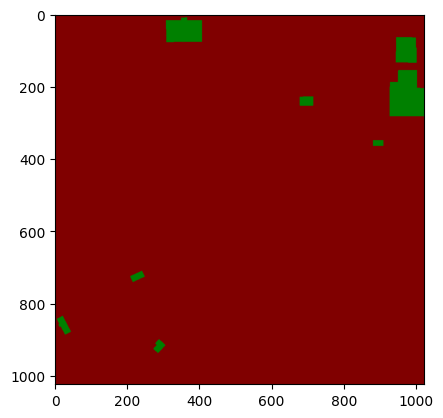

In [14]:
# anno img 확인
sample_img = cv2.imread("./data/annotations/train/TRAIN_0000.png")
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

In [15]:
from mmseg.registry import DATASETS
from mmseg.datasets import BaseSegDataset

@DATASETS.register_module()
class BuildingSegDataset(BaseSegDataset):
  METAINFO = dict(
      classes=("bg", "building"),
      palette=([128, 0, 0], [0, 128, 0])
  )
  def __init__(self,
               img_suffix=".png",
               seg_map_suffix=".png",
               **kwargs):
    super().__init__(
        img_suffix=img_suffix,
        seg_map_suffix=seg_map_suffix,
        **kwargs)


Creat Config File

In [16]:
from mmengine import Config
cfg = Config.fromfile('configs/segnext/segnext_mscan-b_1xb16-adamw-160k_ade20k-512x512.py')
# print(f'Config:\n{cfg.pretty_text}')

In [17]:
# segnext

cfg.model.decode_head.num_classes = 2
cfg.model.decode_head.out_channels = 1
cfg.model.decode_head.threshold = 0.5
cfg.model.decode_head.loss_decode.use_sigmoid = True
cfg.model.decode_head.loss_decode.loss_name = "loss_bce"

# cfg.model.decide_head.loss_decode =

# Modify dataset type and path
cfg.dataset_type = 'BuildingSegDataset'
cfg.data_root = data_root

# train : 7141 * 0.8 -> 5713
# 5713 / 8 -> 715 iter == 1 epoch

cfg.train_cfg.type = "IterBasedTrainLoop"
cfg.train_cfg.max_iters = 7150 # 10 epoch
cfg.train_cfg.val_interval = 3575

cfg.default_hooks.logger.interval = 100
cfg.default_hooks.checkpoint.interval = 715

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', reduce_zero_label=False),
    dict(
        type='RandomResize',
        scale=(2048, 512),
        ratio_range=(0.5, 2.0),
        keep_ratio=True
    ),
    dict(type='RandomCrop', crop_size=(512, 512), cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='PackSegInputs'),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', scale=(2048, 512), keep_ratio=True),
    dict(type='LoadAnnotations', reduce_zero_label=False),
    dict(type='PackSegInputs'),
]


cfg.train_dataloader.num_workers = 3
cfg.train_dataloader.batch_size = 8
cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline
cfg.train_dataloader.dataset.data_prefix = dict(img_path="images/train", seg_map_path="annotations/train")


cfg.val_dataloader.num_workers = 3
cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.val_dataloader.dataset.data_prefix = dict(img_path="images/val", seg_map_path="annotations/val")

cfg.test_dataloader.num_workers = 3
cfg.test_dataloader.dataset.type = cfg.dataset_type
cfg.test_dataloader.dataset.data_root = cfg.data_root
cfg.test_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.test_dataloader.dataset.data_prefix = dict(img_path="images/val", seg_map_path="annotations/val")



cfg['randomness'] = dict(seed=42)
cfg.work_dir = './work_dirs/segnext'

print(f'Config:\n{cfg.pretty_text}')

Config:
default_scope = 'mmseg'
env_cfg = dict(
    cudnn_benchmark=True,
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0),
    dist_cfg=dict(backend='nccl'))
vis_backends = [
    dict(type='LocalVisBackend'),
]
visualizer = dict(
    type='SegLocalVisualizer',
    vis_backends=[
        dict(type='LocalVisBackend'),
    ],
    name='visualizer')
log_processor = dict(by_epoch=False)
log_level = 'INFO'
load_from = None
resume = False
tta_model = dict(type='SegTTAModel')
optimizer = dict(type='SGD', lr=0.01, momentum=0.9, weight_decay=0.0005)
optim_wrapper = dict(
    type='OptimWrapper',
    optimizer=dict(
        type='AdamW', lr=6e-05, betas=(
            0.9,
            0.999,
        ), weight_decay=0.01),
    paramwise_cfg=dict(
        custom_keys=dict(
            pos_block=dict(decay_mult=0.0),
            norm=dict(decay_mult=0.0),
            head=dict(lr_mult=10.0))))
param_scheduler = [
    dict(
        type='LinearLR', start_factor=1e-06, by_epoch=False, beg

In [18]:
from mmengine.runner import Runner

runner = Runner.from_cfg(cfg)

07/06 10:26:39 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.12 (main, Jun  7 2023, 12:45:35) [GCC 9.4.0]
    CUDA available: True
    numpy_random_seed: 42
    GPU 0: Tesla V100-SXM2-16GB
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    GCC: x86_64-linux-gnu-gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
    PyTorch: 2.0.1+cu118
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=comput

/content/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


07/06 10:26:48 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
07/06 10:26:48 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

/content/mmsegmentation/mmseg/engine/hooks/visualization_hook.py:61: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


In [19]:
runner.train()

/content/mmsegmentation/mmseg/datasets/transforms/loading.py:83: UserWarning: `reduce_zero_label` will be deprecated, if you would like to ignore the zero label, please set `reduce_zero_label=True` when dataset initialized
  warnings.warn('`reduce_zero_label` will be deprecated, '
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


07/06 10:26:55 - mmengine - INFO - paramwise_options -- backbone.block1.0.norm1.weight:lr=6e-05
07/06 10:26:55 - mmengine - INFO - paramwise_options -- backbone.block1.0.norm1.weight:weight_decay=0.0
07/06 10:26:55 - mmengine - INFO - paramwise_options -- backbone.block1.0.norm1.weight:decay_mult=0.0
07/06 10:26:55 - mmengine - INFO - paramwise_options -- backbone.block1.0.norm1.bias:lr=6e-05
07/06 10:26:55 - mmengine - INFO - paramwise_options -- backbone.block1.0.norm1.bias:weight_decay=0.0
07/06 10:26:55 - mmengine - INFO - paramwise_options -- backbone.block1.0.norm1.bias:decay_mult=0.0
07/06 10:26:55 - mmengine - INFO - paramwise_options -- backbone.block1.0.norm2.weight:lr=6e-05
07/06 10:26:55 - mmengine - INFO - paramwise_options -- backbone.block1.0.norm2.weight:weight_decay=0.0
07/06 10:26:55 - mmengine - INFO - paramwise_options -- backbone.block1.0.norm2.weight:decay_mult=0.0
07/06 10:26:55 - mmengine - INFO - paramwise_options -- backbone.block1.0.norm2.bias:lr=6e-05
07/06 

Downloading: "https://download.openmmlab.com/mmsegmentation/v0.5/pretrain/segnext/mscan_b_20230227-3ab7d230.pth" to /root/.cache/torch/hub/checkpoints/mscan_b_20230227-3ab7d230.pth


07/06 10:27:10 - mmengine - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: head.weight, head.bias

07/06 10:27:10 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/06 10:27:10 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.
07/06 10:27:10 - mmengine - INFO - Checkpoints will be saved to /content/mmsegmentation/work_dirs/segnext.
07/06 10:28:35 - mmengine - INFO - Iter(train) [ 100/7150]  base_lr: 3.9627e-06 lr: 3.9627e-06  eta: 1:40:20  time: 0.6106  data_time: 0.0392  memory: 13174  loss: 0.2717  decode.loss_bce: 0.2717  decode.acc_seg: 94.9668
07/06 10:29:49 - mmengine - INFO - Iter(train) [ 200/7150]  base_lr: 7.9654e-06 lr: 7.9654e-06  eta: 1:32:06  time: 0.6046  data_time: 0.0323  memory: 11166  loss: 0.2000  decode.loss_bce: 0.2000  decode.acc_seg: 

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


07/06 11:12:48 - mmengine - INFO - Iter(val) [ 100/1428]    eta: 0:01:54  time: 0.1009  data_time: 0.0111  memory: 11166  
07/06 11:12:56 - mmengine - INFO - Iter(val) [ 200/1428]    eta: 0:01:44  time: 0.0523  data_time: 0.0050  memory: 514  
07/06 11:13:02 - mmengine - INFO - Iter(val) [ 300/1428]    eta: 0:01:24  time: 0.0550  data_time: 0.0050  memory: 514  
07/06 11:13:10 - mmengine - INFO - Iter(val) [ 400/1428]    eta: 0:01:18  time: 0.0958  data_time: 0.0139  memory: 514  
07/06 11:13:16 - mmengine - INFO - Iter(val) [ 500/1428]    eta: 0:01:08  time: 0.0545  data_time: 0.0052  memory: 514  
07/06 11:13:22 - mmengine - INFO - Iter(val) [ 600/1428]    eta: 0:00:58  time: 0.0550  data_time: 0.0060  memory: 514  
07/06 11:13:31 - mmengine - INFO - Iter(val) [ 700/1428]    eta: 0:00:53  time: 0.0540  data_time: 0.0074  memory: 514  
07/06 11:13:36 - mmengine - INFO - Iter(val) [ 800/1428]    eta: 0:00:44  time: 0.0548  data_time: 0.0059  memory: 514  
07/06 11:13:43 - mmengine - IN

EncoderDecoder(
  (data_preprocessor): SegDataPreProcessor()
  (backbone): MSCAN(
    (patch_embed1): StemConv(
      (proj): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate='none')
        (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (block1): ModuleList(
      (0): MSCABlock(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (attn): MSCASpatialAttention(
          (proj_1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          (activation): GELU(approximate='none')
          (spatial_gating_unit): MSCAAttention(
            (conv0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=64)
            (conv0_

inference

Loads checkpoint by local backend from path: ./work_dirs/segnext/iter_4290.pth
07/06 12:03:07 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.


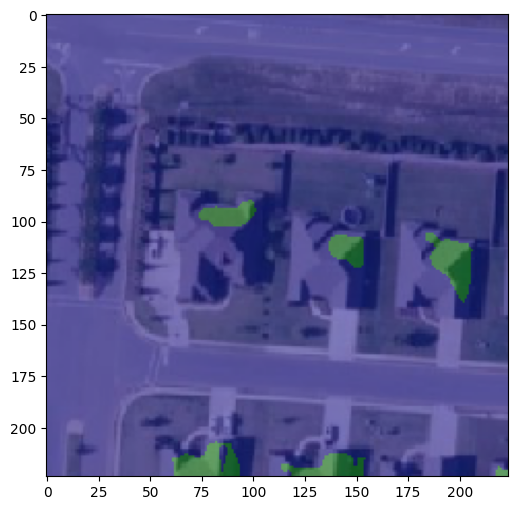

In [23]:
from mmseg.apis import init_model, inference_model, show_result_pyplot

# Init the model from the config and the checkpoint
checkpoint_path = './work_dirs/segnext/iter_4290.pth'
model = init_model(cfg, checkpoint_path, 'cuda:0')

img = mmcv.imread('./data/test_img/TEST_00000.png')
result = inference_model(model, img)
plt.figure(figsize=(8, 6))
vis_result = show_result_pyplot(model, img, result)
plt.imshow(mmcv.bgr2rgb(vis_result))

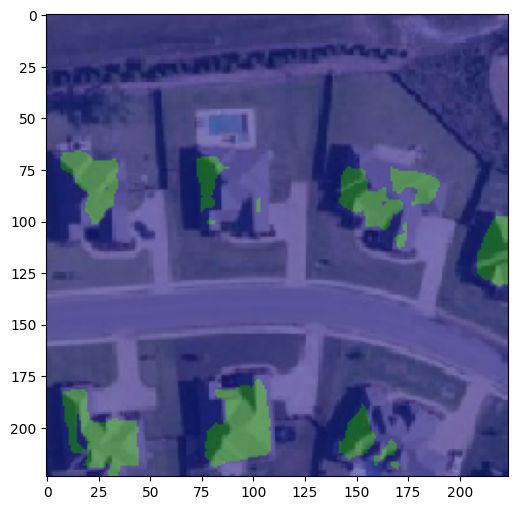

In [32]:
img = mmcv.imread('./data/test_img/TEST_00005.png')
result = inference_model(model, img)
plt.figure(figsize=(8, 6))
vis_result = show_result_pyplot(model, img, result)
plt.imshow(mmcv.bgr2rgb(vis_result))

In [33]:
submit = pd.read_csv("./data/sample_submission.csv")

In [40]:
mask_lst = []
for idx, row in submit.iterrows():
  img = mmcv.imread(f"./data/test_img/{row['img_id']}.png")
  result = inference_model(model, img)
  mask = result.pred_sem_seg.data
  mask = mask.detach().cpu().numpy()
  mask_lst.append(rle_encode(mask))

In [49]:
mask_lst = [-1 if m == '' else m for m in mask_lst]
submit["mask_rle"] = mask_lst
# submit.to_csv("answer.csv", index=False)

In [51]:
submit.to_csv("answer.csv", index=False)

In [ ]:
# test dataloader 수정
# runner.test()